In [1]:
# resnet18 가져올 때 필요함.
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [75]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

from torchvision import transforms, utils
from torchvision.transforms import Resize, ToTensor, Normalize

import time

In [76]:
train_path = 'input/data/train'
train_image_dir_path = os.path.join(train_path, 'images')

Dataset 생성

모든 train data의 path를 가져와 라벨링 진행

In [80]:
def search(dirname, result): # 하위 목록의 모든 파일을 찾는 함수
    try:
        filenames = os.listdir(dirname)
        for filename in filenames:
            if filename[0] == '.': # .으로 시작하는 애들 거름
                continue
            full_filename = os.path.join(dirname, filename)
            if os.path.isdir(full_filename):
                search(full_filename, result)
            else:
                ext = os.path.splitext(full_filename)[-1] # 확장자 체크
                if ext:
                    result.append(full_filename)
        
    except PermissionError:
        print('Permission Error')
        pass

In [5]:
all_path = list()
search(train_image_dir_path, all_path)

train의 데이터 디렉토리는 2700개로, 각각의 이미지 파일(incorrect, mask1~5, normal)을 곱한 갯수가 나옵니다.

In [6]:
len(all_path) # 2700 * 7

18900

In [7]:
all_path[:10]

['input/data/train/images/001752_male_Asian_53/mask5.jpg',
 'input/data/train/images/001752_male_Asian_53/mask4.jpg',
 'input/data/train/images/001752_male_Asian_53/mask2.jpg',
 'input/data/train/images/001752_male_Asian_53/mask3.jpg',
 'input/data/train/images/001752_male_Asian_53/normal.jpg',
 'input/data/train/images/001752_male_Asian_53/mask1.jpg',
 'input/data/train/images/001752_male_Asian_53/incorrect_mask.jpg',
 'input/data/train/images/005127_female_Asian_51/mask5.jpg',
 'input/data/train/images/005127_female_Asian_51/mask4.jpg',
 'input/data/train/images/005127_female_Asian_51/mask2.jpg']

파일의 확장자는 jpg, png, jpeg로 3종류가 있습니다.

In [8]:
exts = list()
for word in all_path:
    ext = os.path.splitext(word)[-1]
    if ext not in exts:
        exts.append(ext)
print(exts) # jpg, png, jpeg

['.jpg', '.png', '.jpeg']


In [9]:
all_path = sorted(all_path)

라벨링을 하는 함수입니다. 조건에 따라 label에 숫자를 더해주는 식으로 만들었습니다.

In [10]:
def labeling(name):
    label = 0
    info, mask_type = name.split('/')[-2:]
    info = info.split('_')
    gender, age = info[1], int(info[3])
    
    # 마스크 구별
    if 'incorrect' in mask_type:
        label += 6
    elif 'normal' in mask_type:
        label += 12
    
    # gender 구별
    if gender == 'female':
        label += 3
    
    # 나이 구별
    if 30 <= age and age < 60:
        label += 1
    elif age >= 60:
        label += 1
    
    return label

path, label을 컬럼으로 갖는 dataframe을 생성해줍니다.

In [86]:
train_path_label = pd.DataFrame(all_path, columns = ['path'])

train_path_label['label'] = train_path_label['path'].map(lambda x: labeling(x))
train_path_label

,path,label
0,input/data/train/images/000001_female_Asian_45...,10
1,input/data/train/images/000001_female_Asian_45...,4
2,input/data/train/images/000001_female_Asian_45...,4
3,input/data/train/images/000001_female_Asian_45...,4
4,input/data/train/images/000001_female_Asian_45...,4
...,...,...
18895,input/data/train/images/006959_male_Asian_19/m...,0
18896,input/data/train/images/006959_male_Asian_19/m...,0
18897,input/data/train/images/006959_male_Asian_19/m...,0
18898,input/data/train/images/006959_male_Asian_19/m...,0


In [12]:
# train_path_label.to_csv('./train_path_label.csv', index=False, encoding='utf-8')

In [13]:
# train_path_label = pd.read_csv('./train_path_label.csv', encoding='utf-8')

dataset을 상속받아 만든 CustomDataset입니다.
transform은 size를 [512, 384]로 변형하고, Tensor로 만들고, 정규화를 해주었습니다.

In [14]:
class CustomDataset(Dataset):
    def __init__(self, img_paths_label, transform):
        self.X = img_paths_label['path']
        self.y = img_paths_label['label']
        self.transform = transform
        
    def __getitem__(self, index):
        image = Image.open(self.X.iloc[index])
        label = self.y.iloc[index]
        
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)
    
    def __len__(self):
        return len(self.X)

In [15]:
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])

train, valid를 나누는 부분입니다.

label의 비율을 유지하면서 나눴습니다.

In [16]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_path_label, test_size=0.2,
                               shuffle=True, stratify=train_path_label['label'],
                               random_state=34)

In [17]:
train.shape, valid.shape

((15120, 2), (3780, 2))

In [100]:
type(train)

pandas.core.frame.DataFrame

dataloader를 정의했습니다. batchsize는 64로 했고 shuffle을 했습니다.

In [18]:
BATCH_SIZE = 64

In [19]:
train_dataset = CustomDataset(train, transform)

train_dataloader = DataLoader(train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True
                             )

In [20]:
valid_dataset = CustomDataset(valid, transform)

valid_dataloader = DataLoader(valid_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

dataloader는 [batchsize, channel, height, wide]를 출력해줍니다.

In [21]:
next(iter(train_dataloader))[0].shape

torch.Size([64, 3, 512, 384])

In [50]:
next(iter(valid_dataloader))[0].shape

torch.Size([64, 3, 512, 384])

 ## 모델
 모델은 pretrain된 resnet18을 가져왔습니다.
 이 모델의 마지막 fc층만 저희의 과제인 18개의 class로 변경해줍니다.

In [22]:
resnet18 = torchvision.models.resnet18(pretrained=True)

In [23]:
import math

OUTPUT_CLASS_NUM = 18
resnet18.fc = torch.nn.Linear(in_features=512, out_features=OUTPUT_CLASS_NUM, bias=True) # output 18개로

# xavier uniform
torch.nn.init.xavier_uniform_(resnet18.fc.weight)
stdv = 1. / math.sqrt(resnet18.fc.weight.size(1))
resnet18.fc.bias.data.uniform_(-stdv, stdv)

resnet18.fc.weight.shape[0]

18

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

아래 대부분의 코드가 부스트캠프에서 학습 자료나 과제로 제공받았던 코드를 거의 그대로 사용했습니다.

설명도 주석도 잘 달려 있어서 그대로 가져왔습니다.


epoch는 5, lr은 0.0001로 주었습니다.

추후에 lr scheduler로 lr을 변경해보는 방법도 좋을 것 같습니다.

In [25]:
resnet18.to(device)

LEARNING_RATE = 0.0001 # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 5 # 학습 때 mnist train data set을 얼마나 많이 학습할 지 결정하는 옵션

loss_fn = torch.nn.CrossEntropyLoss() # 분류 학습 때 많이 사용되는 Cross Entropy Loss를 objective function으로 사용
optimizer = torch.optim.Adam(resnet18.parameters(), lr=LEARNING_RATE) # weight 업데이트를 위한 optimizer를 Adam으로 사용함

dataloaders = {
    "train": train_dataloader,
    "test": valid_dataloader,
}

In [27]:
best_test_accuracy = 0.
best_test_loss = 9999.
start = time.time()  # 시작 시간 저장

for epoch in range(NUM_EPOCH):
    for phase in ["train", "test"]:
        running_loss = 0.
        running_acc = 0.
        # 네트워크 모델을 train 모드로 두어 gradient를 계산하고, 
        # 여러 sub module (배치 정규화, 드롭아웃 등)이 train_mode로 작동할 수 있게 함.
        if phase == "train":
            resnet18.train()
        # 네트워크 모델을 eval 모드로 두어 여러 sub module들이 eval mode로 작동할 수 있게 함.
        elif phase == "test":
            resnet18.eval()
            
        for ind, (images, labels) in enumerate(dataloaders[phase]):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함.
            
            # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
            with torch.set_grad_enabled(phase == "train"):
                logits = resnet18(images)
                # 모델에서 linear 값으로 나오는 예측 값([0.9, 1.2, 3.2, 0.1, -0.1, ...])에서 최대 output index를 찾아 예측 레이블([2])로 변경함
                _, preds = torch.max(logits, 1)
                loss = loss_fn(logits, labels)
                
                if phase == "train":
                    loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient를 계산
                    optimizer.step() # 계산된 gradient를 가지고 모델 업데이트
                    
            running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
            running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장
            
        # 한 epoch이 모두 종료되었을 때,
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)
        
        seconds = int(time.time() - start)
        print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss: {epoch_loss:.3f}, 평균 Accuracy: {epoch_acc:.3f}")
        print(f"소요 시간: {seconds // 60}분 {seconds % 60}초")  # 현재시각 - 시작시간 = 실행 시간
        
        # phase가 test일 때
        if phase == "test":
            # best accuracy 계산
            if best_test_accuracy < epoch_acc:
                best_test_accuracy = epoch_acc
            # best loss 계산
            if best_test_loss > epoch_loss:
                best_test_loss = epoch_loss
                
seconds = int(time.time() - start)
print("학습 종료!")
print(f"최고 accuracy: {best_test_accuracy}, 최고 낮은 loss: {best_test_loss}")
print(f"소요 시간: {seconds // 60}분 {seconds % 60}초")  # 현재시각 - 시작시간 = 실행 시간

현재 epoch-0의 train-데이터 셋에서 평균 Loss: 0.311, 평균 Accuracy: 0.913
소요 시간: 2분 27초
현재 epoch-0의 test-데이터 셋에서 평균 Loss: 0.072, 평균 Accuracy: 0.976
소요 시간: 2분 53초
현재 epoch-1의 train-데이터 셋에서 평균 Loss: 0.032, 평균 Accuracy: 0.993
소요 시간: 5분 20초
현재 epoch-1의 test-데이터 셋에서 평균 Loss: 0.030, 평균 Accuracy: 0.991
소요 시간: 5분 46초
현재 epoch-2의 train-데이터 셋에서 평균 Loss: 0.012, 평균 Accuracy: 0.998
소요 시간: 8분 11초
현재 epoch-2의 test-데이터 셋에서 평균 Loss: 0.026, 평균 Accuracy: 0.992
소요 시간: 8분 37초
현재 epoch-3의 train-데이터 셋에서 평균 Loss: 0.004, 평균 Accuracy: 1.000
소요 시간: 11분 3초
현재 epoch-3의 test-데이터 셋에서 평균 Loss: 0.021, 평균 Accuracy: 0.995
소요 시간: 11분 29초
현재 epoch-4의 train-데이터 셋에서 평균 Loss: 0.003, 평균 Accuracy: 1.000
소요 시간: 13분 56초
현재 epoch-4의 test-데이터 셋에서 평균 Loss: 0.018, 평균 Accuracy: 0.994
소요 시간: 14분 23초
학습 종료!
최고 accuracy: 0.9952381253242493, 최고 낮은 loss: 0.017673718123130067
소요 시간: 14분 23초


In [28]:
start = time.time()  # 시작 시간 저장
seconds = int(time.time() - start)
print(f"소요 시간: {seconds // 60}분 {seconds % 60}초")  # 현재시각 - 시작시간 = 실행 시간

소요 시간: 0분 0초


In [29]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total, n_correct = 0, 0
        model.eval()
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model.forward(batch_in.to(device))
            _, y_pred = torch.max(model_pred, 1) # 행으로 비교
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        # model.train()
        
    return val_accr

In [30]:
func_eval(resnet18, valid_dataloader, device)

0.9941798941798942

실제 정답과 pred를 비교해보려고 path, pred, target을 dataframe으로 만들었습니다.

In [31]:
def check_eval(raw_data, dataloader, model, device):
    result = list()
    with torch.no_grad():
        model.eval()
        for i, (X, y) in enumerate(dataloader):
            model_pred = model.forward(X.to(device))
            _, y_pred = torch.max(model_pred, 1)
            
            result.append([valid.iloc[i]['path'], y_pred.cpu().numpy()[0], y.cpu().numpy()[0]])
    result = pd.DataFrame(result, columns=['path', 'pred', 'target'])
    return result

In [32]:
valid_testing_dataloader = DataLoader(valid_dataset, shuffle=False)

check_eval_df = check_eval(valid, valid_testing_dataloader, resnet18, device)
check_eval_df

,path,pred,target
0,input/data/train/images/000692_female_Asian_55...,16,16
1,input/data/train/images/005213_male_Asian_24/i...,6,6
2,input/data/train/images/005487_female_Asian_48...,16,16
3,input/data/train/images/003414_male_Asian_51/m...,1,1
4,input/data/train/images/000618_male_Asian_37/m...,1,1
...,...,...,...
3775,input/data/train/images/001547_female_Asian_25...,15,15
3776,input/data/train/images/001107_male_Asian_25/m...,0,0
3777,input/data/train/images/001708_female_Asian_55...,4,4
3778,input/data/train/images/000826_female_Asian_55...,16,16


잘못 예측한 데이터만 모아봤습니다.

In [33]:
wrong_df = check_eval_df[check_eval_df['pred'] != check_eval_df['target']]
wrong_df = wrong_df.reset_index(drop=True)
wrong_df

,path,pred,target
0,input/data/train/images/005451_male_Asian_32/n...,12,13
1,input/data/train/images/000685_male_Asian_19/i...,7,6
2,input/data/train/images/005130_female_Asian_29...,10,9
3,input/data/train/images/005544_male_Asian_32/i...,6,7
4,input/data/train/images/001173_male_Asian_30/i...,6,7
5,input/data/train/images/005151_female_Asian_32...,9,10
6,input/data/train/images/001336_male_Asian_26/m...,3,0
7,input/data/train/images/001235_male_Asian_20/m...,6,0
8,input/data/train/images/000225_female_Asian_25...,4,3
9,input/data/train/images/005130_female_Asian_29...,16,15


틀린 데이터들을 살펴보기 위해 이미지와 같이 출력해보겠습니다.

In [48]:
class_list = [[['wear'], ['male'], ['un30']], [['wear'], ['male'], ['3060']], [['wear'], ['male'], ['ov60']],
              [['wear'], ['fema'], ['un30']], [['wear'], ['fema'], ['3060']], [['wear'], ['fema'], ['ov60']],
              [['Inco'], ['male'], ['un30']], [['Inco'], ['male'], ['3060']], [['Inco'], ['male'], ['ov60']],
              [['Inco'], ['fema'], ['un30']], [['Inco'], ['fema'], ['3060']], [['Inco'], ['fema'], ['ov60']],
              [['NoWe'], ['male'], ['un30']], [['NoWe'], ['male'], ['3060']], [['NoWe'], ['male'], ['ov60']],
              [['NoWe'], ['fema'], ['un30']], [['NoWe'], ['fema'], ['3060']], [['NoWe'], ['fema'], ['ov60']]
             ]

def draw_(df):
    plt.figure(figsize = (15, 30))
    row = len(wrong_df) // 3
    # 틀린 번호 찾기
    wrong_number = list()
    for df_path in list(df['path']):
        wrong_number.append(df_path.split('/')[4].split('_')[0])
        
    for i in range(df.shape[0]):
        plt.subplot(row + 1, df.shape[0] // row, i + 1)
        plt.imshow(Image.open(df['path'][i]))
        plt.title(f"target:{class_list[df['target'][i]]}, \n pred: {class_list[df['pred'][i]]} \n id: {wrong_number[i]}", color='r', size=20)
        plt.axis('off')
    print(df)
    

    plt.tight_layout()
    plt.show()

                                                 path  pred  target
0   input/data/train/images/005451_male_Asian_32/n...    12      13
1   input/data/train/images/000685_male_Asian_19/i...     7       6
2   input/data/train/images/005130_female_Asian_29...    10       9
3   input/data/train/images/005544_male_Asian_32/i...     6       7
4   input/data/train/images/001173_male_Asian_30/i...     6       7
5   input/data/train/images/005151_female_Asian_32...     9      10
6   input/data/train/images/001336_male_Asian_26/m...     3       0
7   input/data/train/images/001235_male_Asian_20/m...     6       0
8   input/data/train/images/000225_female_Asian_25...     4       3
9   input/data/train/images/005130_female_Asian_29...    16      15
10  input/data/train/images/001124_male_Asian_30/i...     6       7
11  input/data/train/images/001751_male_Asian_51/m...     4       1
12  input/data/train/images/003792_male_Asian_30/m...     0       1
13  input/data/train/images/000070_female_Asian_

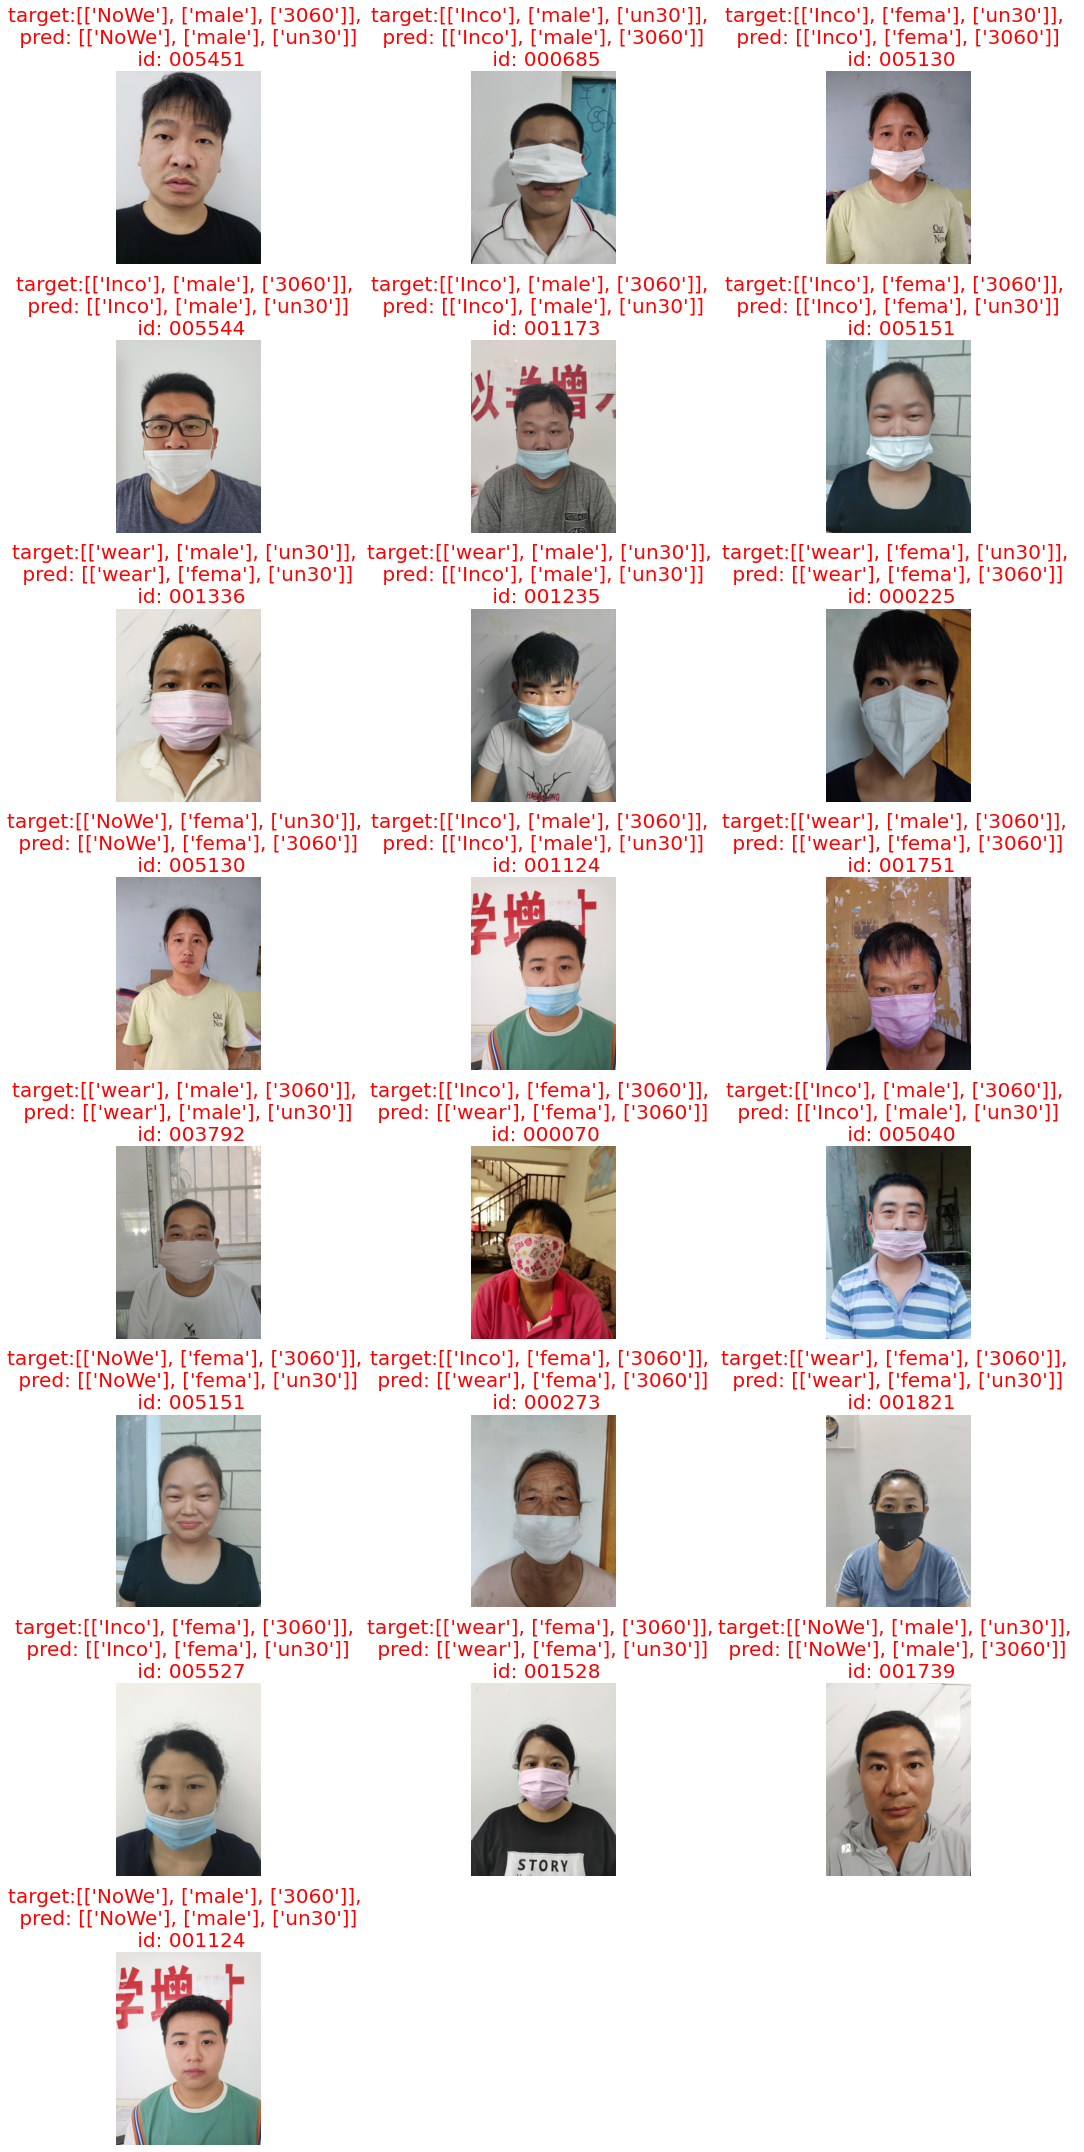

In [49]:
draw_(wrong_df)

나이 틀린 데이터들이 꽤 있는 듯.
f1을 높이려면 precision, recall 둘 다 높여야 하기 때문에 둘을 비교해보는 것도 좋을 듯.

In [40]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
f1_score(check_eval_df['target'], check_eval_df['pred'], average='macro')

0.9893241135560643

제출할 csv 파일 만들기

In [42]:
print(train_path_label)

                                                    path  label
0      input/data/train/images/000001_female_Asian_45...     10
1      input/data/train/images/000001_female_Asian_45...      4
2      input/data/train/images/000001_female_Asian_45...      4
3      input/data/train/images/000001_female_Asian_45...      4
4      input/data/train/images/000001_female_Asian_45...      4
...                                                  ...    ...
18895  input/data/train/images/006959_male_Asian_19/m...      0
18896  input/data/train/images/006959_male_Asian_19/m...      0
18897  input/data/train/images/006959_male_Asian_19/m...      0
18898  input/data/train/images/006959_male_Asian_19/m...      0
18899  input/data/train/images/006959_male_Asian_19/n...     12

[18900 rows x 2 columns]


In [43]:
print(check_eval_df)

                                                   path  pred  target
0     input/data/train/images/000692_female_Asian_55...    16      16
1     input/data/train/images/005213_male_Asian_24/i...     6       6
2     input/data/train/images/005487_female_Asian_48...    16      16
3     input/data/train/images/003414_male_Asian_51/m...     1       1
4     input/data/train/images/000618_male_Asian_37/m...     1       1
...                                                 ...   ...     ...
3775  input/data/train/images/001547_female_Asian_25...    15      15
3776  input/data/train/images/001107_male_Asian_25/m...     0       0
3777  input/data/train/images/001708_female_Asian_55...     4       4
3778  input/data/train/images/000826_female_Asian_55...    16      16
3779  input/data/train/images/006161_male_Asian_20/n...    12      12

[3780 rows x 3 columns]


In [73]:
model = torch.load(CustomDataset)

AttributeError: type object 'CustomDataset' has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

In [72]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = 'input/data/eval'

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = CustomDataset(valid, transform)
loader = DataLoader(
    dataset,
    shuffle=False
)

print(list(loader))
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = list()
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
        
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



AttributeError: 'list' object has no attribute 'to'

In [ ]:
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

In [41]:
train_path_label.to_csv('./train_path_label.csv', index=False, encoding='utf-8')

csv 파일 불러오기

In [ ]:
# train_path_label = pd.read_csv('./train_path_label.csv', encoding='utf-8')

In [ ]:
# 절반만 freeze

# 정재윤_T3201님이 모두에게 04:46 PM
# ct = 0 
# for child in resnet.children():
#     ct += 1  
#     # 미리 학습된 모델의 일부layer만 업데이트하도록 설정하려면 parameter를 업데이트하지않을 상위 layer의 requires_grad=False로 지정하면 된다.
#     # 전체 10개 layer에서 1~5번 layer는 업데이트 x, 6~10번 layer는 업데이트
#     if ct < 6:
#         for param in child.parameters(): # child.parameters()는 각 layer의 parameter tensor를 의미하고 각텐서의 requires_grad는 True로 지정되어있다.
#             param.requires_grad = False


In [84]:
ans = train_dataset + valid_dataset
print(list(ans)[:10])

[(tensor([[[ 0.7353,  0.7353,  0.7353,  ...,  1.4020,  1.4020,  1.4020],
         [ 0.6765,  0.6765,  0.6765,  ...,  1.4216,  1.4020,  1.4020],
         [ 0.5980,  0.5980,  0.6176,  ...,  1.4216,  1.4216,  1.4020],
         ...,
         [ 1.1863,  1.2059,  1.2059,  ...,  0.5392,  0.5392,  0.5588],
         [ 1.1863,  1.2059,  1.2059,  ...,  0.5392,  0.5392,  0.5392],
         [ 1.1863,  1.2059,  1.2059,  ...,  0.5392,  0.5588,  0.5392]],

        [[-1.9118, -1.9118, -1.9118,  ...,  1.4020,  1.4020,  1.4020],
         [-1.8725, -1.8725, -1.8725,  ...,  1.4216,  1.4020,  1.4020],
         [-1.8333, -1.8333, -1.8333,  ...,  1.4216,  1.4216,  1.4020],
         ...,
         [ 1.1667,  1.1863,  1.1863,  ...,  0.3627,  0.3627,  0.3824],
         [ 1.1667,  1.1863,  1.1863,  ...,  0.3627,  0.3627,  0.3627],
         [ 1.1667,  1.1863,  1.1863,  ...,  0.3627,  0.3824,  0.3627]],

        [[-1.6176, -1.6176, -1.6373,  ...,  1.3627,  1.3627,  1.3627],
         [-1.6373, -1.6373, -1.6373,  ..., 

In [87]:
answer_path_label = pd.DataFrame(all_path, columns = ['answer'])

answer_path_label['answer'] = answer_path_label['answer'].map(lambda x: labeling(x))
answer_path_label

,answer
0,10
1,4
2,4
3,4
4,4
...,...
18895,0
18896,0
18897,0
18898,0


In [98]:
PATH = '/input'

torch.save(resnet18, PATH)

In [94]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [99]:
model11 = torch.load(PATH)
model11.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  